# Population discovery
> Runtime: about 40s.

For population discovery, you will need an additional package: `leidenalg`. You can either install it directly (e.g., with `pip`), or install the "discovery" extra from scyan: `pip install "scyan[discovery]"`.

In [1]:
import scyan

Global seed set to 0


## Model initialization and fitting
> If you use your own dataset, use `Scyan` default parameters first.

In [2]:
adata, marker_pop_matrix = scyan.data.load("bmmc", table="discovery")

model = scyan.Scyan(adata, marker_pop_matrix, temperature=2.5, hidden_size=32, n_hidden_layers=8, n_layers=8, prior_std=0.35)

INFO:scyan.model:Initialized Scyan model with N=61725 cells, P=16 populations and M=13 markers. No covariate provided.


Note that, for this example, we don't have information about the following populations (compared to the original table): Mature CD4+ T, Naive CD4+ T, Mature CD8+ T, Naive CD8+ T, Mature CD38mid B, and Mature CD38lo B.

Instead, we only have larger populations (see below):
- CD4+ T
- CD8+ T
- Mature B

In [3]:
model.pop_names

Index(['CD4+ T', 'CD8+ T', 'CD11bhi Monocyte', 'CD11b- Monocyte', 'Pre-B I',
       'Pre-B II', 'Immature B', 'Mature B', 'NK', 'Plasmacytoid DC', 'CMP',
       'GMP', 'HSC', 'MEP', 'MPP', 'Plasma cell'],
      dtype='object')

In [4]:
model.fit(min_delta=2, patience=2)

INFO:scyan.model:Training scyan with the following hyperparameters:
"alpha_batch_effect": 50.0
"batch_key":          None
"batch_ref":          None
"batch_size":         16384
"hidden_size":        32
"lr":                 0.001
"max_samples":        200000
"mmd_max_samples":    2048
"modulo_temp":        2
"n_hidden_layers":    8
"n_layers":           8
"prior_std":          0.35
"temperature":        2.5

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type        | Params
---------------------------------------
0 | module | ScyanModule | 149 K 
---------------------------------------
149 K     Trainable params
0         Non-trainable params
149 K     Total params
0.597     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

INFO:scyan.model:Successfully ended traning.


Scyan model with N=61725 cells, P=16 populations and M=13 markers. No covariate provided.

In [5]:
model.predict();  # Predictions are saved in adata.obs.scyan_pop by default

We can see that we now have only large clusters corresponding to CD4+ T, CD8+ T, and Mature B cells. As intented, Scyan predicted only the population names from the table, but we can retrieve the missing subpopulations with population discovery (see next section).

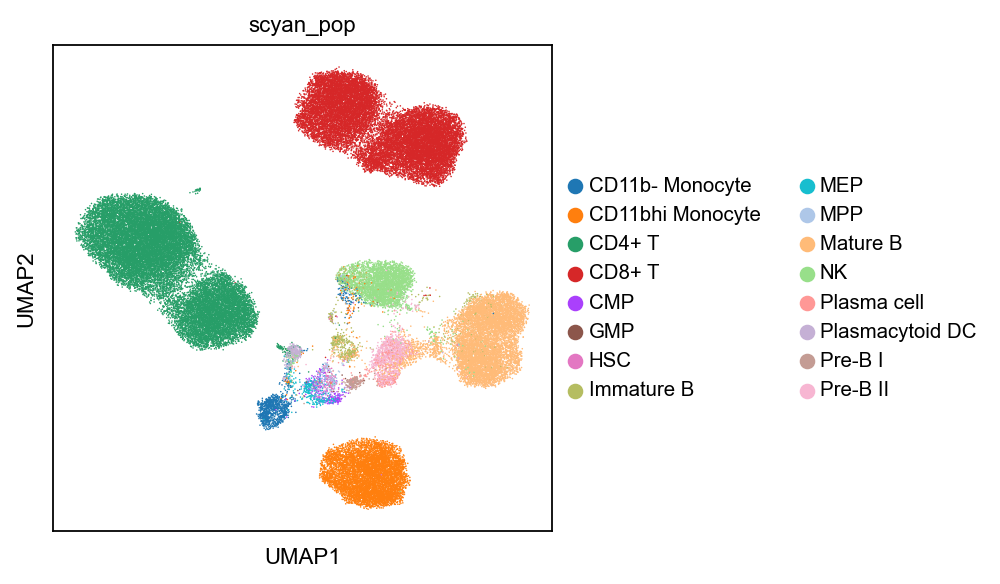

In [6]:
scyan.plot.umap(adata, color="scyan_pop")

## Retrieving the missing populations with population discovery

In [7]:
# Run leiden clustering and filter small clusters (according to a threshold in terms on ratio of cells)
scyan.tools.subcluster(model, resolution=0.5)

computing neighbors
    using data matrix X directly


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:05)


Scyan found 6 interesting clusters to analyse:

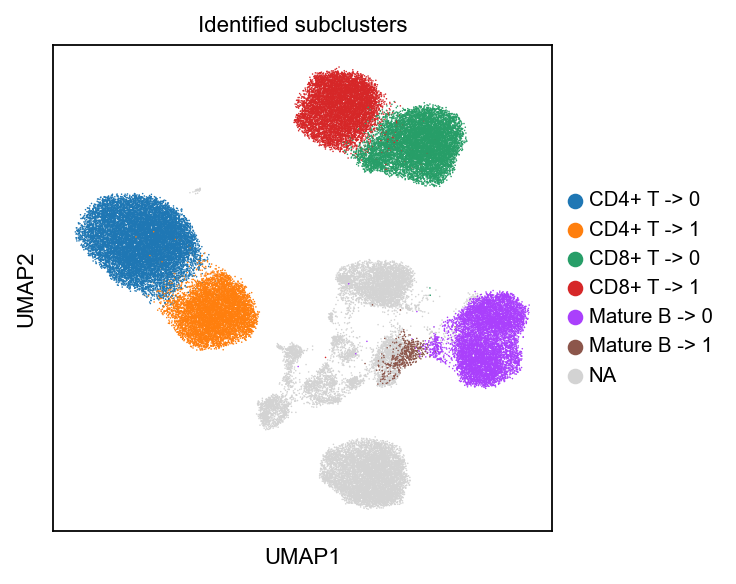

In [8]:
scyan.plot.umap(adata, color="leiden_subcluster", title="Identified subclusters")

We can see that we retrieved the subpopulations that we removed from the table:
- The subcluster 0 of `CD4+ T` corresponds to `Mature CD4+ T` cells.
- The subcluster 1 of `CD4+ T` corresponds to `Naive CD4+ T` cells.
- The subcluster 0 of `CD8+ T` corresponds to `Mature CD4+ T` cells.
- The subcluster 1 of `CD8+ T` corresponds to `Naive CD4+ T` cells.
- The subcluster 0 of `Mature B` corresponds to `Mature CD38lo B` cells.
- The subcluster 1 of `Mature B` corresponds to `Mature CD38mid B` cells.

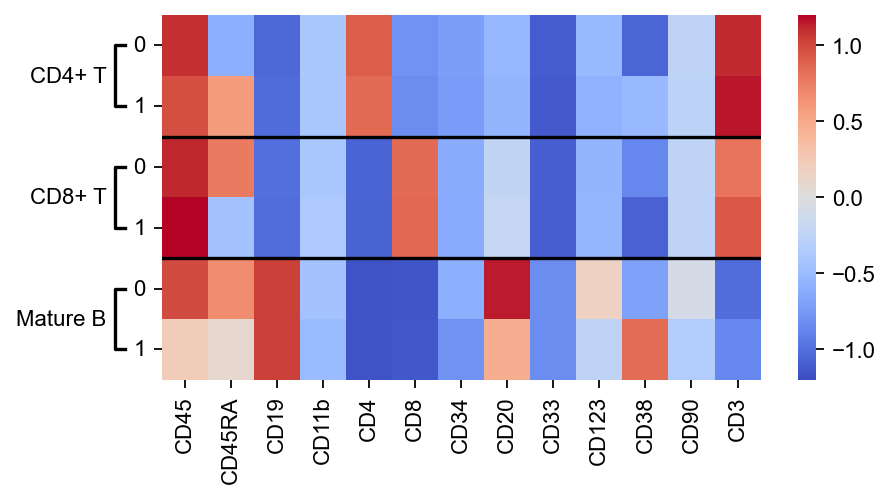

In [9]:
scyan.plot.subcluster(model, figsize=(6, 3))